# Reading netcdf data into tensorflow

Tensorflow has a Dataset object that is recommended for performant workflows. It is a beefed up generator class that has several useful methods:

* batch() : return a stacked array of N items instead of single items
* map() : map a function that changes the tensors as they pass through
* prefetch() : load N items to an in-memory queue, in advance of usage with GPU
* interleave() : parallel loading?

I think it is a good idea to create a netcdf to Dataset method or best practice.

There are 3 methods to create a tensorflow Dataset object:

* tf.data.Dataset.from_generator
* tf.data.Dataset.from_tensor_slices
* tf.data.Dataset.from_tensors

In [1]:
import tensorflow as tf
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# short cut to grab a set of netcdf files
ncfiles = !find /users/rsg/anla/scratch/network/21_02_shiptracks/data/from_mageo/ -name "*nc"

## from_generator

In [6]:

def rgb_netcdf_to_tensor(ncfile) -> tf.Tensor:
    # load netcdf as xr.dataarray and convert to tf.Tensor
    # transpose RGB channels to last dimension and downcast
    # to float32. Tensorflow expects this I think
    
    ds = xr.load_dataarray(ncfile)
    ds = ds.transpose(...,'bands').astype('float32')

    return tf.convert_to_tensor(ds)

def ncfiles_to_dataset(ncfiles) -> tf.data.Dataset:
    # given list of netcdf files, return a tf Dataset

    # this syntax returns a callable that itself returns iterable
    # necessary for use with tensorflow's from_generator function
    gen = lambda: (rgb_netcdf_to_tensor(x) for x in ncfiles)

    return tf.data.Dataset.from_generator(gen, output_types='float')

def resize_image(X:tf.Tensor) -> tf.Tensor:
    return tf.image.resize(
        images = X,
        size = IMAGE_SHAPE
    )

In [7]:
IMAGE_SHAPE = 448*5,448*3

In [8]:
IMAGE_SHAPE

(2240, 1344)

In [9]:
tfds = ncfiles_to_dataset(ncfiles[:10])

In [10]:
# padded batch can handle different shapes, just padds out
tfds = tfds.padded_batch(5, padded_shapes=(2040,1354,3), padding_values=0.0, drop_remainder=True)

In [11]:
tfds

<PaddedBatchDataset shapes: (5, 2040, 1354, 3), types: tf.float32>

In [12]:
for x in tfds:
    print(x.shape)

(5, 2040, 1354, 3)
(5, 2040, 1354, 3)


In [13]:
def resize_image(X:tf.Tensor) -> tf.Tensor:
    return tf.image.resize(
        images = X,
        size = IMAGE_SHAPE
    )

In [14]:
# map a splitting of the array
tfds = tfds.map(resize_image)

In [15]:
tfds

<MapDataset shapes: (5, 2240, 1344, 3), types: tf.float32>

In [16]:
def stitch_up(X):
    # nested concat split calls to
    # stitch back together a image
    # from a 5 x 3 grid of sub-images
    return tf.concat(
            tf.split(
                tf.concat(
                    tf.split(
                        X,
                        3, axis=0
                    ),
                    axis=2
                ),
                5,
                axis=0
            ),
            axis=1
        )

def cut_squares(X):
    # nested split concat calls
    # to break image into 5 x 3 grid
    # of 448 * 448 sub-images
    return tf.concat(
        tf.split(
            tf.concat(
                tf.split(X, 5, axis=1),
                axis=0
            ),
            3,
            axis=2)
        ,
        axis=0
    )

In [17]:
tfds = tfds.map(cut_squares)

In [18]:
tfds

<MapDataset shapes: (75, 448, 448, 3), types: tf.float32>

In [19]:
tfds = tfds.map(stitch_up)

In [20]:
tfds

<MapDataset shapes: (5, 2240, 1344, 3), types: tf.float32>

In [21]:
tfds.map

<bound method DatasetV2.map of <MapDataset shapes: (5, 2240, 1344, 3), types: tf.float32>>

In [22]:
(x), = tfds.take(1)

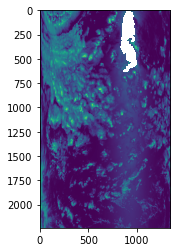

In [27]:
plt.imshow(x[0,:,:,0])

In [23]:
tfds = tfds.prefetch(10)

In [24]:
tfds

<PrefetchDataset shapes: (5, 2240, 1344, 3), types: tf.float32>

## Dataset.list_files

`tf.data.Dataset.list_files` could be a useful starting point. It returns an instance of a `ShuffleDataset` which has several methods inherited from `Dataset`. However, I find that netcdf files cannot be opened from this context...

In [202]:
ds_files = tf.data.Dataset.list_files("/users/rsg/anla/scratch/network/21_02_shiptracks/data/from_mageo/2010/01/01/*.nc")

In [203]:
ds_files

<ShuffleDataset shapes: (), types: tf.string>

In [204]:
ds = ds_files.map(netcdf_to_tensor)

ValueError: in user code:

    <ipython-input-3-3e2fd60a978b>:3 netcdf_to_tensor  *
        return tf.convert_to_tensor(xr.open_dataarray(X).transpose('y','x','bands').astype('float32'))
    /users/rsg/anla/anaconda3/envs/tf_geo/lib/python3.8/site-packages/xarray/backends/api.py:652 open_dataarray  *
        dataset = open_dataset(
    /users/rsg/anla/anaconda3/envs/tf_geo/lib/python3.8/site-packages/xarray/backends/api.py:479 open_dataset  *
        engine = plugins.guess_engine(filename_or_obj)
    /users/rsg/anla/anaconda3/envs/tf_geo/lib/python3.8/site-packages/xarray/backends/plugins.py:111 guess_engine  *
        raise ValueError(

    ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'zarr']. Consider explicitly selecting one of the installed backends via the ``engine`` parameter to xarray.open_dataset(), or installing additional IO dependencies:
    http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
    http://xarray.pydata.org/en/stable/user-guide/io.html
